In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import h5py


/home/sourav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = h5py.File('train_catvnoncat.h5','r+')
list(train.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [3]:
train_set_x=np.array(train['train_set_x'][:])
train_set_y=np.array(train['train_set_y'][:])
test  = h5py.File('test_catvnoncat.h5', "r")
test_set_x=np.array(test['test_set_x'][:])
test_set_y=np.array(test['test_set_y'][:])
classes=np.array(train['list_classes'][:])

In [4]:
train_set_x.shape, test_set_x.shape

((209, 64, 64, 3), (50, 64, 64, 3))

 0 = not cat 
 1 = cat
 1


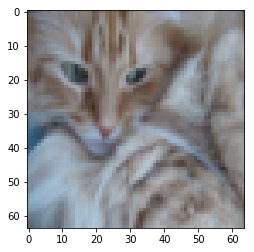

In [5]:
index = 2
plt.imshow(train_set_x[index])
print(" 0 = not cat \n 1 = cat\n", train_set_y[index])


In [6]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [7]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [8]:
def new_conv_layer(input, #previous layer
              num_input_channels, #no. of channels prev. layer
              filter_size, # width and height
              num_filters, 
              use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    weights = new_weights(shape)
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1],padding='SAME')
    
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1],padding="SAME")
    
    layer = tf.nn.relu(layer)
    
    return layer,weights

In [9]:

train_set_y.shape, test_set_y.shape

((209,), (50,))

In [10]:
#convert data to one hot encoded data
train_y = tf.convert_to_tensor(train_set_y)
test_y = tf.convert_to_tensor(test_set_y)
tf.reshape(train_y,(209,1))
tf.reshape(test_y,(50,1))
train_y = tf.one_hot(train_y,2)
test_y = tf.one_hot(test_y,2)
train_y
with tf.Session() as sess:  
    train_y = sess.run(train_y) #converted to numpy array
    test_y = sess.run(test_y)

In [12]:
x = tf.placeholder(tf.float32, shape=[None, 64,64,3], name='x')

In [13]:
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='y_true')

In [14]:
conv1, w_conv1 = \
    new_conv_layer(input = x,
                   num_input_channels=3, #depth
                   filter_size = 5, 
                   num_filters = 16, #no of output channel
                   use_pooling = True) 

In [15]:
conv2, w_conv2 = \
    new_conv_layer(input=conv1,
                   num_input_channels= 16,
                   filter_size = 5,
                   num_filters = 32,
                   use_pooling = True)

In [16]:
conv3, w_conv3 = \
    new_conv_layer(input=conv2,
                   num_input_channels= 32,
                   filter_size = 5,
                   num_filters = 64,
                   use_pooling = True)

In [17]:
w_fc1 = new_weights((8*8*64,1024))
b_fc1 = new_biases(length=1024)

In [18]:
out_from_conv3 = tf.reshape(conv3, [-1,8*8*64])
fc1 = tf.nn.relu(tf.matmul(out_from_conv3,w_fc1) + b_fc1)

In [19]:
w_fc2 = new_weights([1024, 2])
b_fc2 = new_biases(2)

y = tf.matmul(fc1, w_fc2) + b_fc2 # NO activation at last layer

In [20]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=[1]))
train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)

In [21]:
correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

Instructions for updating:
Use `argmax` instead


In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(8):
        if i % 2 == 0 :
            train_accuracy =sess.run(accuracy, feed_dict={x:train_set_x, y_:train_y })
            print("step {}, training accuracy {}".format(i, train_accuracy))
         
        sess.run(train_step, feed_dict = {x:train_set_x, y_:train_y})   
        

step 0, training accuracy 0.6555023789405823
step 2, training accuracy 0.3444976210594177
step 4, training accuracy 0.6555023789405823
step 6, training accuracy 0.6555023789405823


In [23]:
with tf.Session() as sess:
    a = sess.run([accuracy], feed_dict = {x: test_set_x, y_: test_y})

FailedPreconditionError: Attempting to use uninitialized value Variable_1
	 [[Node: Variable_1/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_1)]]

Caused by op 'Variable_1/read', defined at:
  File "/home/sourav/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sourav/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3d008f36e44f>", line 5, in <module>
    use_pooling = True)
  File "<ipython-input-8-0fe2e7f9c778>", line 9, in new_conv_layer
    biases = new_biases(length=num_filters)
  File "<ipython-input-7-fd3f3d05b3c2>", line 2, in new_biases
    return tf.Variable(tf.constant(0.05, shape=[length]))
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 397, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 142, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3187, in identity
    "Identity", input=input, name=name)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/sourav/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_1
	 [[Node: Variable_1/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_1)]]
